#Name:- Ankush Dey

#Roll:- MDS202108

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.util import random_noise
import math

###1. (a) Adding noise: Add the following kinds of noise to the image either by image addition or by using the OpenCV function for 

###i. Gaussian noise 

###ii. Salt-and-pepper noise 

###iii. Periodic noise

In [2]:
bookpage = cv.imread("/content/bookpage.jpg",0)
checkerboard = cv.imread("/content/checkerboard.png",0)
fingerprint1 = cv.imread("/content/fingerprint1.jpg",0)
fingerprint2 = cv.imread("/content/fingerprint2.jpg",0)
building = cv.imread("/content/building.jpg",0)
notch_1 = cv.imread("/content/notch1.jpg",0)
notch_2 = cv.imread("/content/notch2.png",0)
notch_3 = cv.imread("/content/notch3.jpg",0)
objects = cv.imread("/content/objects.png",0)

In [3]:
# Add Gaussian noise to the image
noise_gauss = random_noise(checkerboard, mode='gaussian', mean = 0, var = 0.05)*255

# Add salt-and-pepper noise to the image.
noise_salt = random_noise(checkerboard, mode='s&p', amount = 0.15)*255

# Add periodic noise
noise = np.zeros((checkerboard.shape[0], checkerboard.shape[1]), dtype='float64')
X, Y = np.meshgrid(range(0, checkerboard.shape[0]), range(0, checkerboard.shape[1]))
noise += 10*np.cos(30*X + 45*Y) + (-10)*np.cos(-30*X + 45*Y)

noise_periodic = checkerboard + noise
noise_periodic += np.abs(np.amin(checkerboard + noise))
noise_periodic = (noise_periodic/np.amax(noise_periodic))*255

Text(0.5, 1.0, 'Periodic Noise')

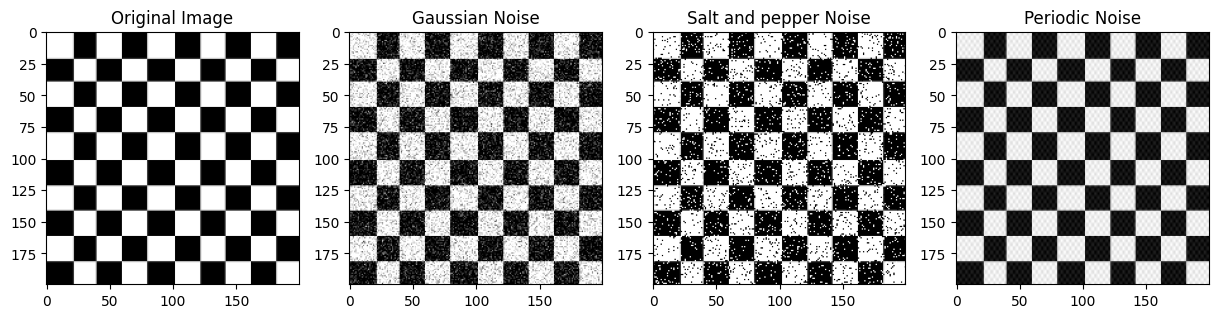

In [4]:
fig, axs = plt.subplots(1,4, figsize = (15,10))
axs[0].imshow(checkerboard,cmap='gray')
axs[0].set_title("Original Image")
axs[1].imshow(noise_gauss,cmap='gray')
axs[1].set_title("Gaussian Noise")
axs[2].imshow(noise_salt,cmap='gray')
axs[2].set_title("Salt and pepper Noise")
axs[3].imshow(noise_periodic,cmap='gray')
axs[3].set_title("Periodic Noise")

####(b) De-noising: de-noise the images obtained above. Experiment with various filters such as smoothing Gaussian filter, median filter and the notch filter (for periodic noise) to see what works best. You may try other filters too.

In [5]:
def gaussian_notch_filter(fshift, points, d0 = 0.5):
    m = fshift.shape[0]
    n = fshift.shape[1]
    for u in range(m):
        for v in range(n):
            for d in range(len(points)):
                u0 = points[d][0]
                v0 = points[d][1]

                d1 = pow(pow(u - u0, 2) + pow(v - v0, 2), 0.5)
                d2 = pow(pow(u + u0, 2) + pow(v + v0, 2), 0.5)
                fshift[u][v] *= (1 - np.exp(-0.5 * (d1 * d2 / pow(d0, 2))))

    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

def ideal_notch_filter(fshift, points, d0 = 0):
    m = fshift.shape[0]
    n = fshift.shape[1]
    for u in range(m):
        for v in range(n):
            for d in range(len(points)):
                u0 = points[d][0]
                v0 = points[d][1]
                u0, v0 = v0, u0
                d1 = pow(pow(u - u0, 2) + pow(v - v0, 2), 1)
                d2 = pow(pow(u + u0, 2) + pow(v + v0, 2), 1)
                if d1 <= d0 or d2 <= d0:
                    fshift[u][v] *= 0.0
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

def butterworth_notch_filter(fshift, points, d0 = 0.5, order = 1):
    m = fshift.shape[0]
    n = fshift.shape[1]
    for u in range(m):
        for v in range(n):
            for d in range(len(points)):
                u0 = points[d][0]
                v0 = points[d][1]

                eps = 1e-5
                d1 = pow(pow(u - u0, 2) + pow(v - v0, 2), 0.5) + eps
                d2 = pow(pow(u + u0, 2) + pow(v + v0, 2), 0.5) + eps
                fshift[u][v] *= (1.0 / (1 + pow((d0 * d0) / (d1 * d2), order))) 

    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

In [6]:
def apply_notch(img, filter_type, limit = 5, increment = 10, size = 12):
    
    # Fourier transform to get the magnitude spectrum
    f = np.fft.fft2(img)
    f_shift = np.fft.fftshift(f)
    trans_image = 20*np.log(1 + np.abs(np.fft.fftshift(f)))
    
    # To select points where the spikes occur
    # list which stores the spikes other than the dc component
    l = list(np.zeros(size * 2))
    
    # to store the coordinates of the points
    coordinates = []
    
    # storing the values of spikes in a list
    while(len(l) > size):
        l = [i for i in trans_image.ravel() if i > limit]
        l = l[:int(len(l)/2)] + l[int(len(l)/2+ 1): ]
        limit += increment
        
    # Find the spikes other than dc component to reduce noise
    for i in range(trans_image.shape[0]):
        for j in range(trans_image.shape[1]):
            if trans_image[i,j] in l:
                coordinates.append((i, j))
            
    # Type of filter
    if filter_type == 'Ideal':
        result = ideal_notch_filter(f_shift, coordinates)
        
    if filter_type == 'Gaussian':
        result = gaussian_notch_filter(f_shift, coordinates)
        
    if filter_type == 'Butterworth':
        result = butterworth_notch_filter(f_shift, coordinates)

    return(result)

In [7]:
def denoise(img, limit = 5, increment = 1):
    
    # Gaussian filter
    denoise_gauss = cv.GaussianBlur(img, (5,5), 1.5)

    # Median filter
    denoise_med = cv.medianBlur(img.astype('uint8'), 5)
    
    # Butterworth
    denoise_notch_bw = apply_notch(img.copy(), filter_type = 'Butterworth', limit = limit, increment = increment)
    
    # Ideal
    denoise_notch_ideal = apply_notch(img.copy(), filter_type = 'Ideal', limit = limit, increment = increment)
    
    return denoise_gauss, denoise_med, denoise_notch_bw, denoise_notch_ideal
    
def denoise_notch(img, limit = 5, increment = 1):
    
    # Notch filters
    denoise_notch_gauss = apply_notch(img.copy(), filter_type = 'Gaussian', limit = limit, increment = increment)
    denoise_notch_bw = apply_notch(img.copy(), filter_type = 'Butterworth', limit = limit, increment = increment)
    denoise_notch_ideal = apply_notch(img.copy(), filter_type = 'Ideal', limit = limit, increment = increment)
    
    return denoise_notch_gauss, denoise_notch_bw, denoise_notch_ideal

In [8]:
denoise_gauss_gauss, denoise_gauss_med, denoise_gauss_bw, denoise_gauss_ideal = denoise(noise_gauss)
denoise_sap_gauss, denoise_sap_med, denoise_sap_bw, denoise_sap_ideal = denoise(noise_salt)
denoise_per_gauss, denoise_per_med, denoise_per_bw, denoise_per_ideal = denoise(noise_periodic)

Text(0.5, 1.0, 'Ideal Notch Filter')

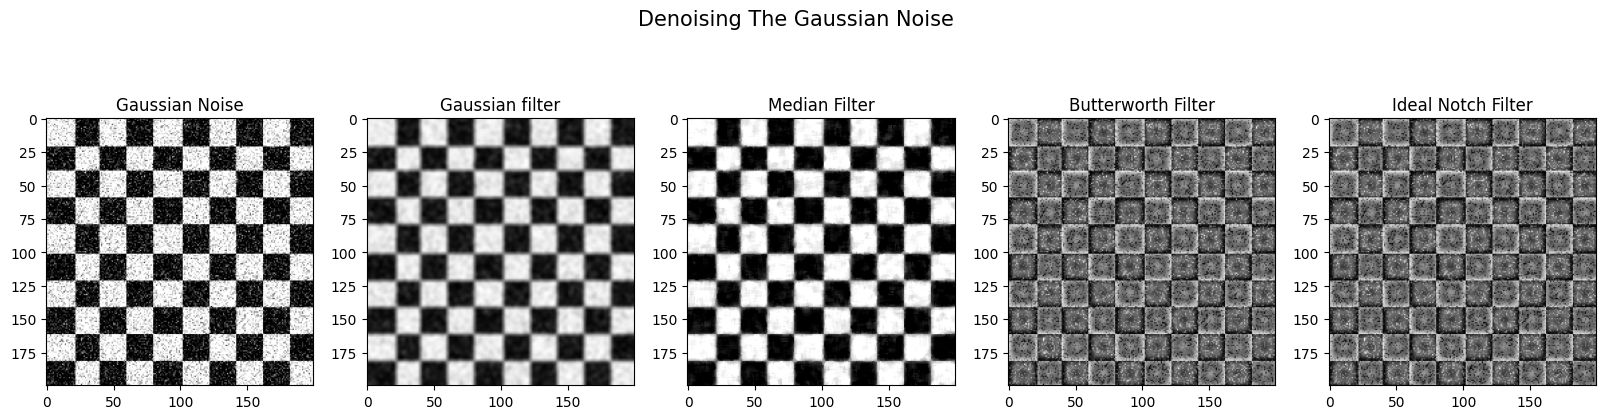

In [9]:
fig, axs = plt.subplots(1,5, figsize = (20, 5))
fig.suptitle('Denoising The Gaussian Noise', fontsize=15)
axs[0].imshow(noise_gauss,cmap='gray')
axs[0].set_title("Gaussian Noise")
axs[1].imshow(denoise_gauss_gauss,cmap='gray')
axs[1].set_title("Gaussian filter")
axs[2].imshow(denoise_gauss_med,cmap='gray')
axs[2].set_title("Median Filter")
axs[3].imshow(denoise_gauss_bw,cmap='gray')
axs[3].set_title("Butterworth Filter")
axs[4].imshow(denoise_gauss_ideal,cmap='gray')
axs[4].set_title("Ideal Notch Filter")



Text(0.5, 1.0, 'Ideal Notch Filter')

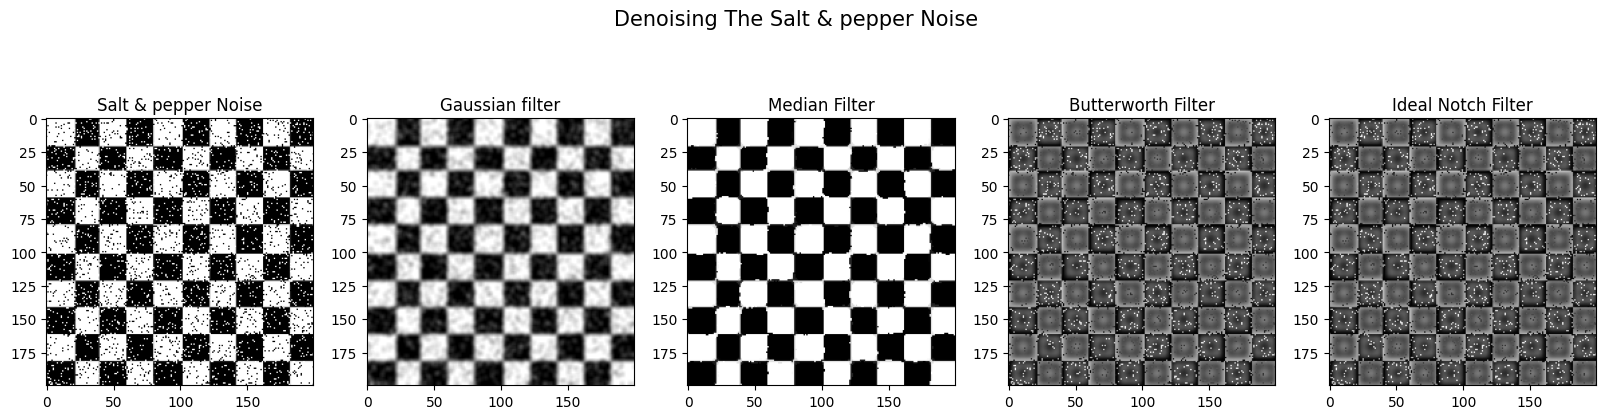

In [10]:
fig, axs = plt.subplots(1,5, figsize = (20, 5))
fig.suptitle('Denoising The Salt & pepper Noise', fontsize=15)
axs[0].imshow(noise_salt,cmap='gray')
axs[0].set_title("Salt & pepper Noise")
axs[1].imshow(denoise_sap_gauss,cmap='gray')
axs[1].set_title("Gaussian filter")
axs[2].imshow(denoise_sap_med,cmap='gray')
axs[2].set_title("Median Filter")
axs[3].imshow(denoise_sap_bw,cmap='gray')
axs[3].set_title("Butterworth Filter")
axs[4].imshow(denoise_sap_ideal,cmap='gray')
axs[4].set_title("Ideal Notch Filter")

Text(0.5, 1.0, 'Ideal Notch Filter')

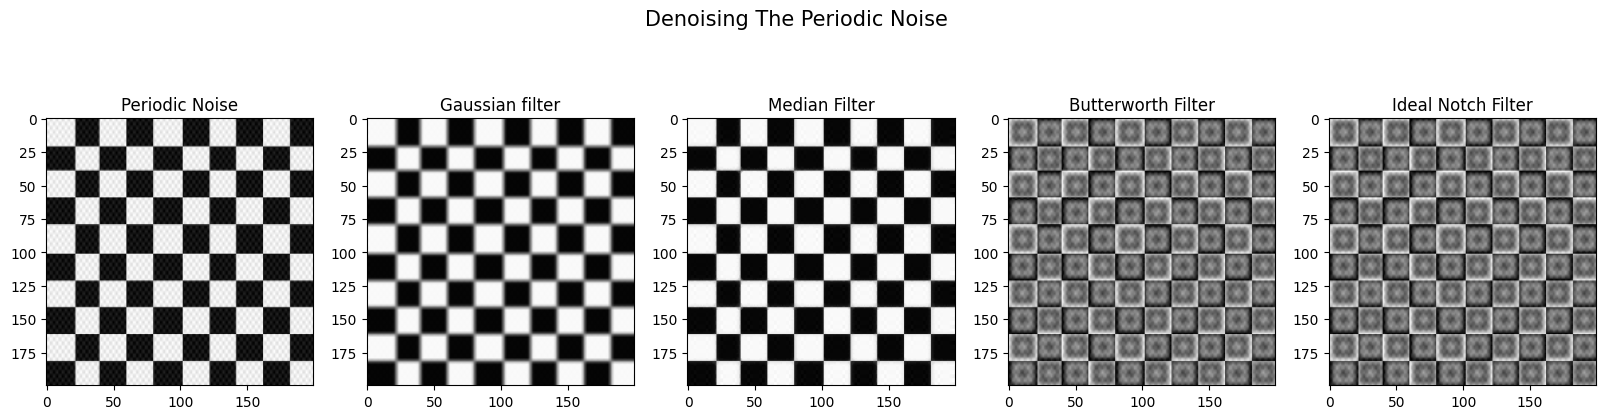

In [11]:
fig, axs = plt.subplots(1,5, figsize = (20, 5))
fig.suptitle('Denoising The Periodic Noise', fontsize=15)
axs[0].imshow(noise_periodic,cmap='gray')
axs[0].set_title("Periodic Noise")
axs[1].imshow(denoise_per_gauss,cmap='gray')
axs[1].set_title("Gaussian filter")
axs[2].imshow(denoise_per_med,cmap='gray')
axs[2].set_title("Median Filter")
axs[3].imshow(denoise_per_bw,cmap='gray')
axs[3].set_title("Butterworth Filter")
axs[4].imshow(denoise_per_ideal,cmap='gray')
axs[4].set_title("Ideal Notch Filter")

From above images we can see that mdeian filter works best for Gaussian and salt pepeper noise.

None of the methods work well in denoising periodic noise (median filter is working comaratively better, but not satisfactorily).

Moreover, notch filters, which have been used exclusively to remove periodic noise, failed miserably in doing so.

####(c) Apply the ideal, Gaussian and Butterworth notch filters on the images ‘notch1.jpg’, ‘notch2.png’ and ‘notch3.jpg’, and compare the results.

In [12]:
# Notch 1 image
%%time
denoise_notch1_gauss, denoise_notch1_bw, denoise_notch1_ideal = denoise_notch(notch_1)

# Notch 2 image
denoise_notch2_gauss, denoise_notch2_bw, denoise_notch2_ideal = denoise_notch(notch_2)

# Notch 3 image
denoise_notch3_gauss, denoise_notch3_bw, denoise_notch3_ideal = denoise_notch(notch_3, limit = 200, increment = 100)

CPU times: user 2min 31s, sys: 377 ms, total: 2min 31s
Wall time: 2min 33s


Text(0.5, 1.0, 'ideal Filter')

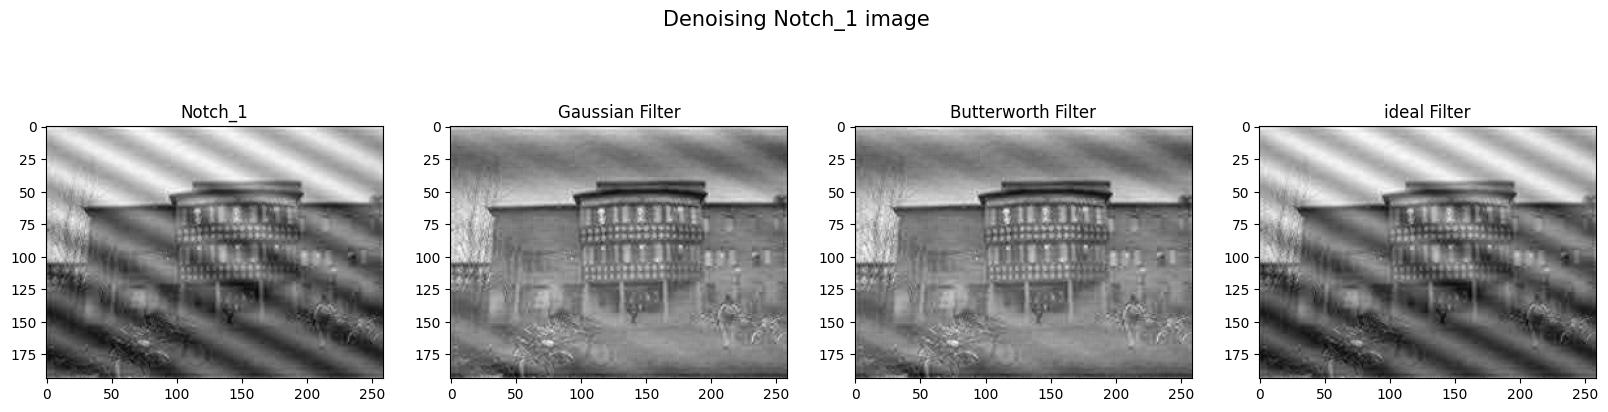

In [13]:
fig, axs = plt.subplots(1,4, figsize = (20, 5))
fig.suptitle('Denoising Notch_1 image', fontsize=15)
axs[0].imshow(notch_1,cmap='gray')
axs[0].set_title("Notch_1")
axs[1].imshow(denoise_notch1_gauss,cmap='gray')
axs[1].set_title("Gaussian Filter")
axs[2].imshow(denoise_notch1_bw,cmap='gray')
axs[2].set_title("Butterworth Filter")
axs[3].imshow(denoise_notch1_ideal,cmap='gray')
axs[3].set_title("ideal Filter")

Text(0.5, 1.0, 'ideal Filter')

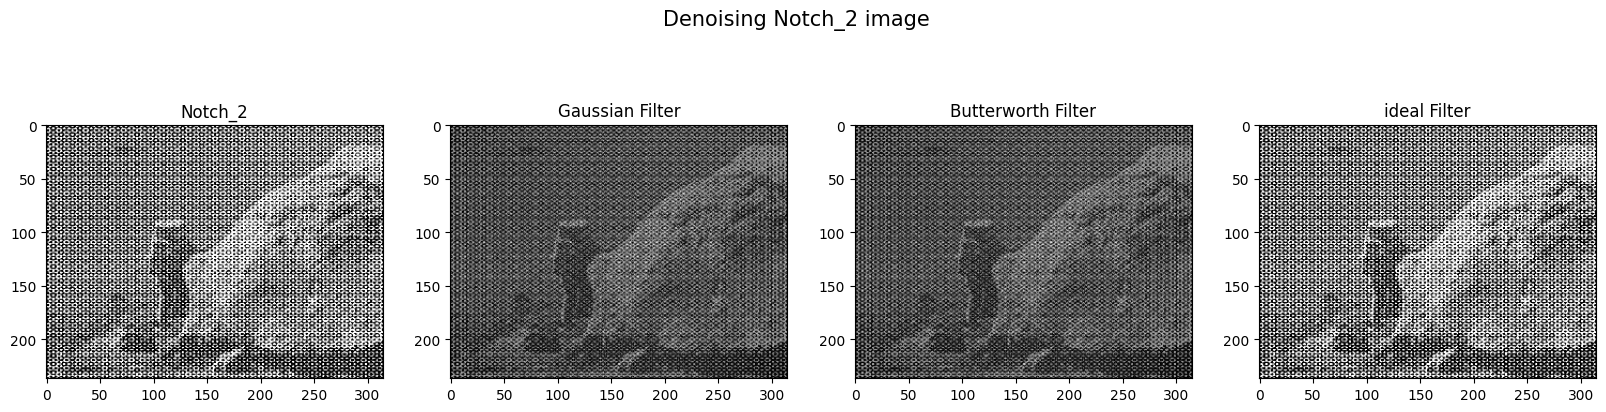

In [14]:
fig, axs = plt.subplots(1,4, figsize = (20, 5))
fig.suptitle('Denoising Notch_2 image', fontsize=15)
axs[0].imshow(notch_2,cmap='gray')
axs[0].set_title("Notch_2")
axs[1].imshow(denoise_notch2_gauss,cmap='gray')
axs[1].set_title("Gaussian Filter")
axs[2].imshow(denoise_notch2_bw,cmap='gray')
axs[2].set_title("Butterworth Filter")
axs[3].imshow(denoise_notch2_ideal,cmap='gray')
axs[3].set_title("ideal Filter")

Text(0.5, 1.0, 'ideal Filter')

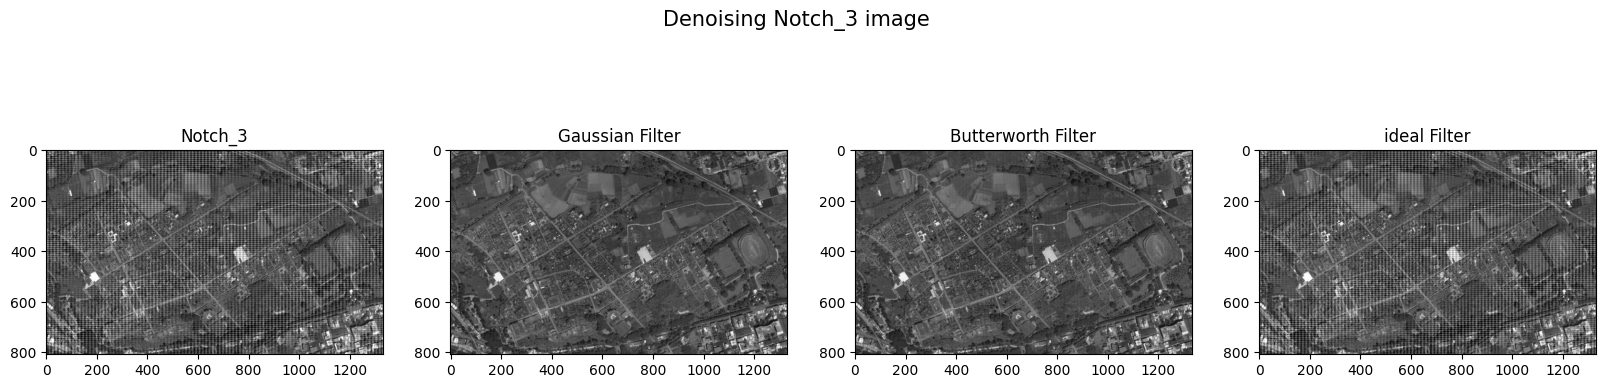

In [15]:
fig, axs = plt.subplots(1,4, figsize = (20, 5))
fig.suptitle('Denoising Notch_3 image', fontsize=15)
axs[0].imshow(notch_3,cmap='gray')
axs[0].set_title("Notch_3")
axs[1].imshow(denoise_notch3_gauss,cmap='gray')
axs[1].set_title("Gaussian Filter")
axs[2].imshow(denoise_notch3_bw,cmap='gray')
axs[2].set_title("Butterworth Filter")
axs[3].imshow(denoise_notch3_ideal,cmap='gray')
axs[3].set_title("ideal Filter")

From the above plots, we see that the three notch filters (Ideal, Gaussian and Butterworth) used here works more or less same for each of the three images. It is also worthy to note that for the first two images, the filters are not working satisfactorily in removing the periodic noise. But, for the 3rd image ('notch3.jpg'), they work significantly good in cleaning the noise.

###2. Thresholding comparisons: threshold the images ‘fingerprint1.jpg’, ‘fingerprint2.jpg’ and ‘bookpage.jpg’ using the first three methods. Display the histogram for each image and observe how the threshold is working each time. Say which method is giving you the best threshold in each case and why.

Text(0.5, 1.0, 'Bookpage')

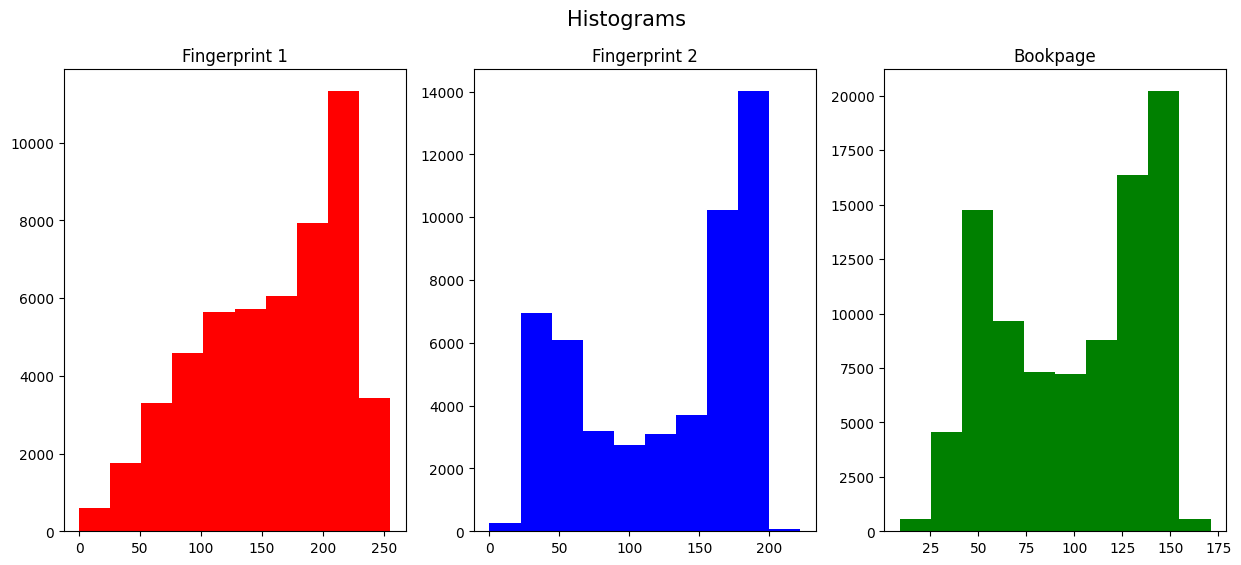

In [16]:
fig, axs = plt.subplots(1,3, figsize=(15,6))
fig.suptitle("Histograms",fontsize=15)
axs[0].hist(fingerprint1.flatten(),color='red')
axs[0].set_title("Fingerprint 1")
axs[1].hist(fingerprint2.flatten(),color='blue')
axs[1].set_title("Fingerprint 2")
axs[2].hist(bookpage.flatten(),color='green')
axs[2].set_title("Bookpage")

####(a) Manual thresholding - manually choose the threshold after observing the histogram.

fingerprint1 :- 130

fingerprint2 :- 100

Bookpage :- 80


In [17]:
# Global thresholding
_, manual_finger1 = cv.threshold(fingerprint1, 130, 255, cv.THRESH_BINARY)
_, manual_finger2 = cv.threshold(fingerprint2, 100, 255, cv.THRESH_BINARY)
_, manual_book = cv.threshold(bookpage, 80, 255, cv.THRESH_BINARY)

Text(0.5, 1.0, 'Bookpage (After Threshholding)')

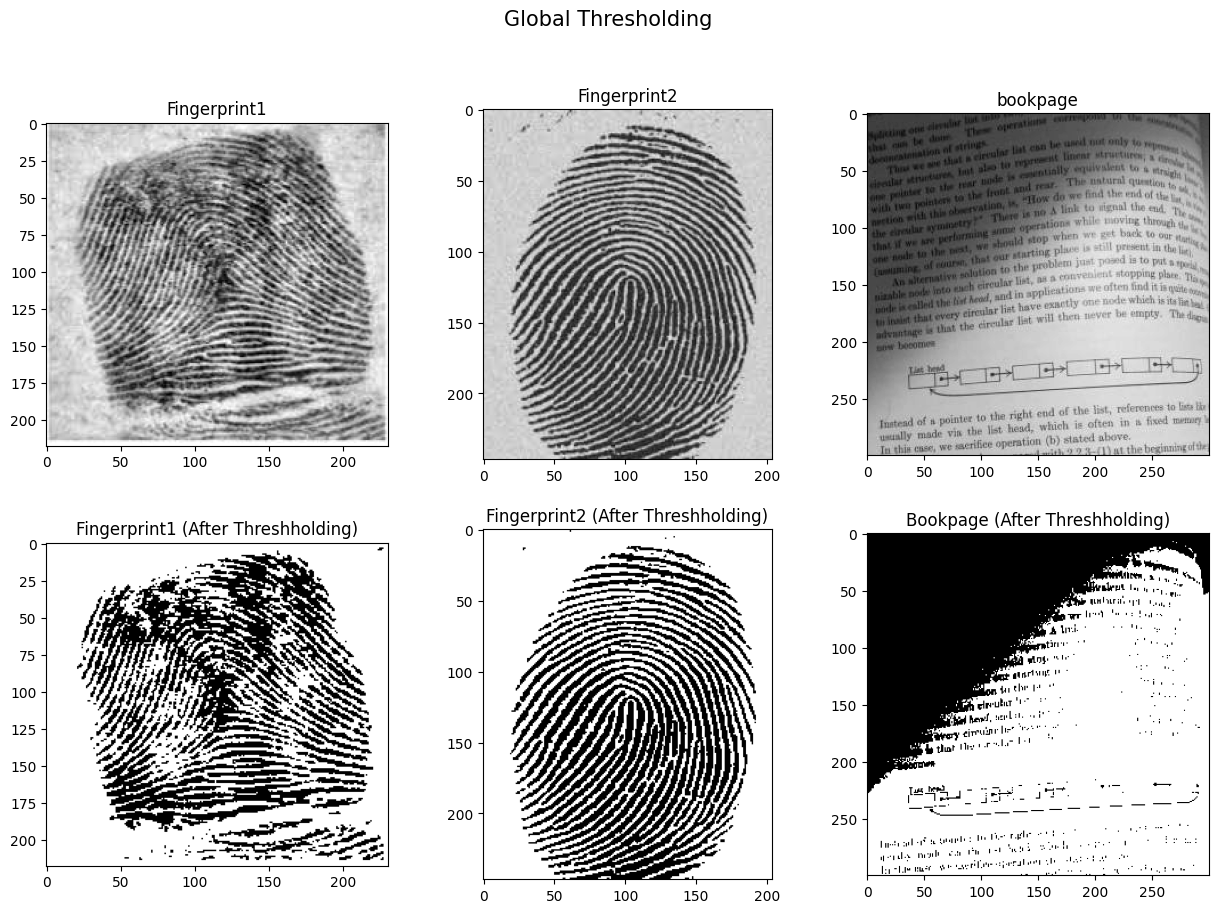

In [18]:
fig, axs = plt.subplots(2,3, figsize = (15,10))
plt.suptitle("Global Thresholding",fontsize=15)
axs[0,0].imshow(fingerprint1,cmap='gray')
axs[0,0].set_title("Fingerprint1")
axs[0,1].imshow(fingerprint2,cmap='gray')
axs[0,1].set_title("Fingerprint2")
axs[0,2].imshow(bookpage,cmap='gray')
axs[0,2].set_title("bookpage")
axs[1,0].imshow(manual_finger1,cmap='gray')
axs[1,0].set_title("Fingerprint1 (After Threshholding)")
axs[1,1].imshow(manual_finger2,cmap='gray')
axs[1,1].set_title("Fingerprint2 (After Threshholding)")
axs[1,2].imshow(manual_book,cmap='gray')
axs[1,2].set_title("Bookpage (After Threshholding)")

#### (b) Global Thresholding

It is same as manual thresholding that we have done above

####(c) Otsu’s method - measure the effectiveness of thresholding using the ratio of variances.

In [19]:
ret1, otsu_finger1 = cv.threshold(fingerprint1,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
ret2, otsu_finger2 = cv.threshold(fingerprint2,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
ret3, otsu_book = cv.threshold(bookpage,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

In [20]:
print('Threshold for fingerprint 1: ', ret1)
print('Threshold for fingerprint 2: ', ret2)
print('Threshold for bookpage: ', ret3)

Threshold for fingerprint 1:  149.0
Threshold for fingerprint 2:  113.0
Threshold for bookpage:  95.0


Text(0.5, 1.0, 'Bookpage (After Threshholding)')

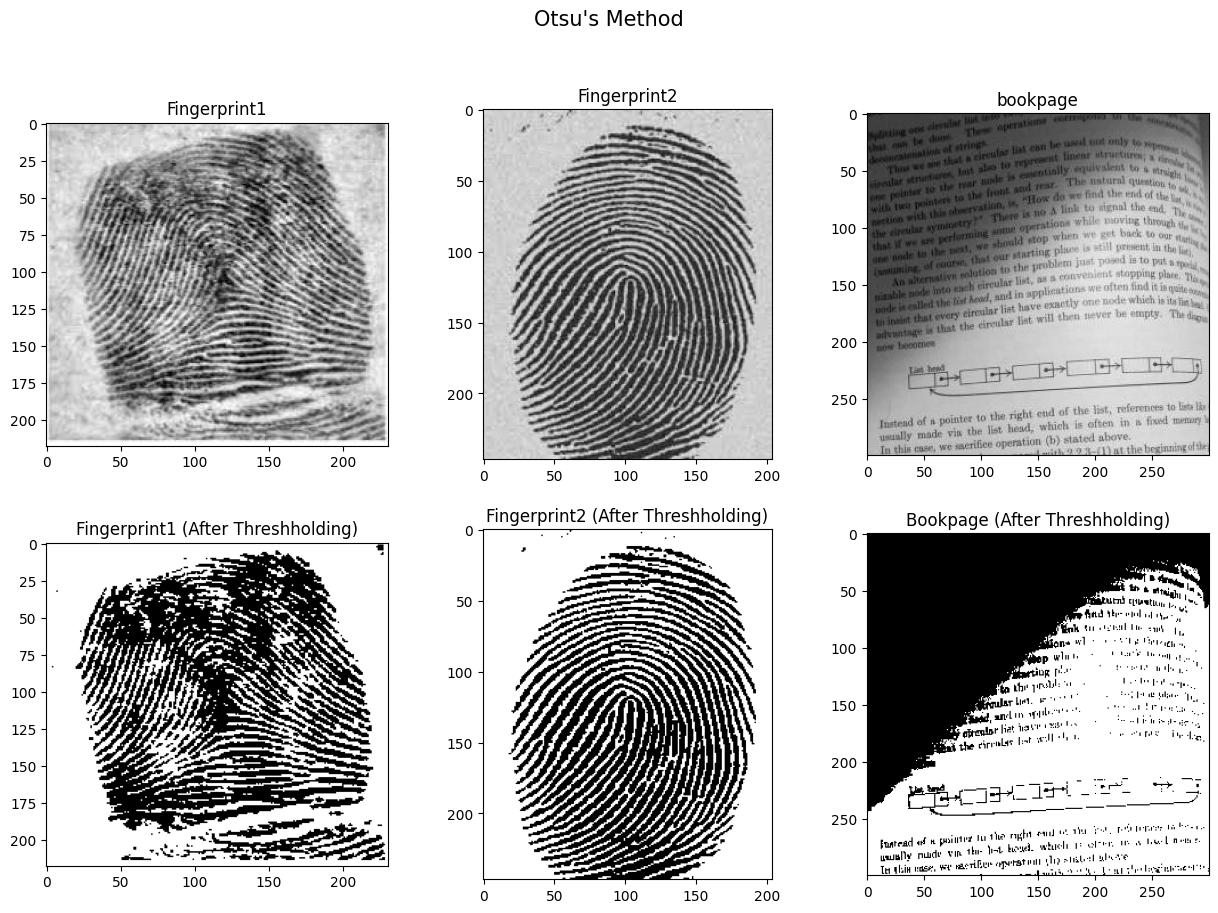

In [21]:
fig, axs = plt.subplots(2,3, figsize = (15,10))
plt.suptitle("Otsu's Method",fontsize=15)
axs[0,0].imshow(fingerprint1,cmap='gray')
axs[0,0].set_title("Fingerprint1")
axs[0,1].imshow(fingerprint2,cmap='gray')
axs[0,1].set_title("Fingerprint2")
axs[0,2].imshow(bookpage,cmap='gray')
axs[0,2].set_title("bookpage")
axs[1,0].imshow(otsu_finger1,cmap='gray')
axs[1,0].set_title("Fingerprint1 (After Threshholding)")
axs[1,1].imshow(otsu_finger2,cmap='gray')
axs[1,1].set_title("Fingerprint2 (After Threshholding)")
axs[1,2].imshow(otsu_book,cmap='gray')
axs[1,2].set_title("Bookpage (After Threshholding)")

####(d) Adaptive thresholding: try both mean and Gaussian.

In [22]:
adapt_mean_finger1 = cv.adaptiveThreshold(fingerprint1, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2)
adapt_gauss_finger1 = cv.adaptiveThreshold(fingerprint1, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)

adapt_mean_finger2 = cv.adaptiveThreshold(fingerprint2, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2)
adapt_gauss_finger2 = cv.adaptiveThreshold(fingerprint2, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)

adapt_mean_book = cv.adaptiveThreshold(bookpage, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2)
adapt_gauss_book = cv.adaptiveThreshold(bookpage, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)

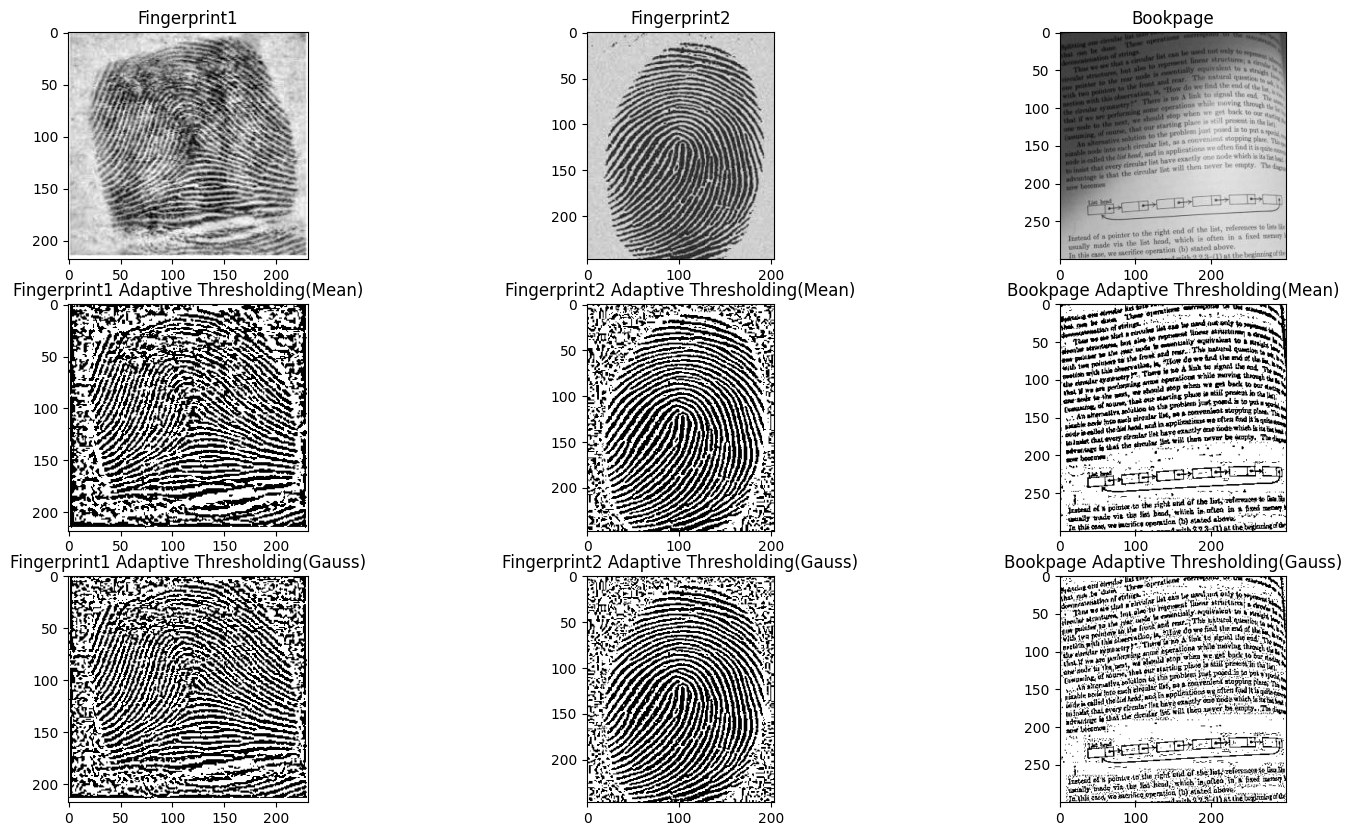

In [23]:
fig, axs = plt.subplots(3,3, figsize = (18,10))
img = [fingerprint1,fingerprint2,bookpage,adapt_mean_finger1,adapt_mean_finger2,adapt_mean_book,
       adapt_gauss_finger1,adapt_gauss_finger2,adapt_gauss_book]
title = ['Fingerprint1','Fingerprint2','Bookpage','Fingerprint1 Adaptive Thresholding(Mean)',
         "Fingerprint2 Adaptive Thresholding(Mean)",'Bookpage Adaptive Thresholding(Mean)',
         "Fingerprint1 Adaptive Thresholding(Gauss)","Fingerprint2 Adaptive Thresholding(Gauss)",
         "Bookpage Adaptive Thresholding(Gauss)"]
k = 0
for i in range(0,3):
    for j in range(0,3):
        axs[i,j].imshow(img[k],cmap='gray')
        axs[i,j].set_title(title[k])
        k = k+1

We observe that for fingerprint1 and fingerprint2, Global thresholding and Otsu's method work better than adaptive thresholding method. Otsu's method for finding the threshold provides slightly better results than Global thresholding. This is because in Global thresholding, we decide the threshold manually, whereas in Otsu's method we use the ratio of variances to fix the threshold.

Adaptive thresholding methods (Gaussian and mean), work better than Global thresholding and Otsu's method for the bookpage image. The two types of adaptive thresholding method, Gaussian and mean, provide comparable results.

###3. Apply the following edge detection techniques to the image ‘building.jpg’ and compare the results. In each case apply Gaussian smoothing before applying edge detection and thresholding after.Experiment to see which thresholding method works best in the given case.
###(a) Sobel kernel
###(b) LoG (finding zero crossings)
###(c) Canny edge detector
###(d) Hough transform
###Repeat the above steps for the image ‘objects.png’. Write down your observations. In particular, note the differences observed in results when the methods are applied to an image with more straight edges in contrast to an image that has more curves. Can you explain these observations?

In [24]:
def zero_crossing(image):
    z_c_image = np.zeros(image.shape)
    
    # Count the number of positive and negative pixels in the neighborhood for each pixel
     
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            negative_count = 0
            positive_count = 0
            neighbour = [image[i+1, j-1],image[i+1, j],image[i+1, j+1],
                         image[i, j-1],image[i, j+1],
                         image[i-1, j-1],image[i-1, j],image[i-1, j+1]]
            d = max(neighbour)
            e = min(neighbour)
            for h in neighbour:
                if h>0:
                    positive_count += 1
                elif h<0:
                    negative_count += 1


            # If both negative and positive values exist in 
            # the pixel neighborhood, then that pixel is a 
            # potential zero crossing
            
            z_c = ((negative_count > 0) and (positive_count > 0))
            
            # Change the pixel value with the maximum neighborhood
            # difference with the pixel

            if z_c:
                if image[i,j]>0:
                    z_c_image[i, j] = image[i,j] + np.abs(e)
                elif image[i,j]<0:
                    z_c_image[i, j] = np.abs(image[i,j]) + d
                
    # Normalize and change datatype to 'uint8' (optional)
    z_c_norm = z_c_image/z_c_image.max()*255
    z_c_image = np.uint8(z_c_norm)

    return z_c_image

#Sobel Filter
def sobel_kernel(img):
    gauss_img = cv.GaussianBlur(img, (3, 3), 1.5)
    # Applying a Sobel filter
    sobel_x = cv.Sobel(gauss_img.copy(), ddepth = cv.CV_16S, dx = 1, dy = 0, ksize = 3)
    sobel_y = cv.Sobel(gauss_img.copy(), ddepth = cv.CV_16S, dx = 0, dy = 1, ksize = 3)
    
    abs_sobel_x = cv.convertScaleAbs(sobel_x)
    abs_sobel_y = cv.convertScaleAbs(sobel_y)
    
    grad = cv.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
    _, sobel_img = cv.threshold(grad, 50, 255, cv.THRESH_BINARY)
    return sobel_img

#Laplacian of Gaussian
def LoG_edge(img):
    gauss_img = cv.GaussianBlur(img, (3, 3), 1.5)
    # Laplacian of Gaussian
    laplace = cv.Laplacian(gauss_img.copy(), cv.CV_64F)
    log_temp = zero_crossing(laplace)
    _, log_img = cv.threshold(log_temp, 35, 255, cv.THRESH_BINARY)
    return log_img

# Canny edge detector
def canny_edge(img):
    gauss_img = cv.GaussianBlur(img, (3, 3), 1.5)
    canny_img = cv.Canny(gauss_img.copy(), 50, 100)
    return canny_img

# Hough transform
def hough_edge(img):
    dst = cv.Canny(img, 50, 100)
    cdstP = np.copy(dst)
    
    linesP = cv.HoughLinesP(dst, 1, np.pi / 180, 50, None, 50, 10)
    
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (255, 0, 0), 3, cv.LINE_AA)
    return cdstP


In [25]:
sobel_building = sobel_kernel(building)
LoG_building = LoG_edge(building)
canny_building = canny_edge(building)
hough_building = hough_edge(building) 

Text(0.5, 1.0, 'Hough Filter')

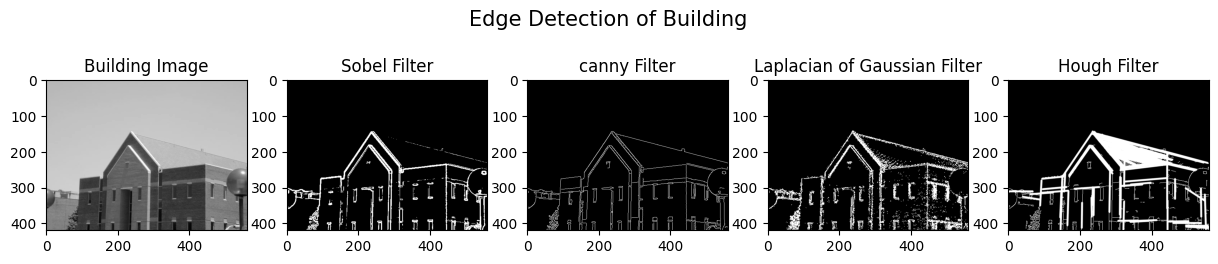

In [26]:
fig, axs = plt.subplots(1,5, figsize=(15,3))
plt.suptitle("Edge Detection of Building",fontsize=15)
axs[0].imshow(building,cmap='gray')
axs[0].set_title("Building Image")
axs[1].imshow(sobel_building,cmap='gray')
axs[1].set_title("Sobel Filter")
axs[2].imshow(canny_building,cmap='gray')
axs[2].set_title("canny Filter")
axs[3].imshow(LoG_building,cmap='gray')
axs[3].set_title("Laplacian of Gaussian Filter")
axs[4].imshow(hough_building,cmap='gray')
axs[4].set_title("Hough Filter")

In [27]:
sobel_objects = sobel_kernel(objects)
LoG_objects = LoG_edge(objects)
canny_objects = canny_edge(objects)
hough_objects = hough_edge(objects) 

Text(0.5, 1.0, 'Hough Filter')

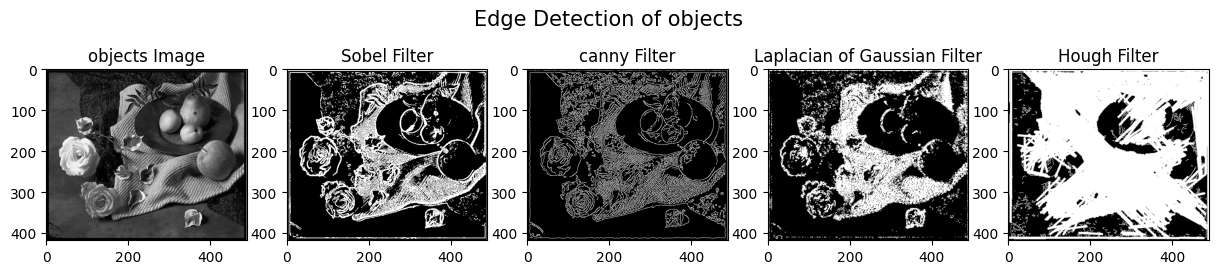

In [28]:
fig, axs = plt.subplots(1,5, figsize=(15,3))
plt.suptitle("Edge Detection of objects",fontsize=15)
axs[0].imshow(objects,cmap='gray')
axs[0].set_title("objects Image")
axs[1].imshow(sobel_objects,cmap='gray')
axs[1].set_title("Sobel Filter")
axs[2].imshow(canny_objects,cmap='gray')
axs[2].set_title("canny Filter")
axs[3].imshow(LoG_objects,cmap='gray')
axs[3].set_title("Laplacian of Gaussian Filter")
axs[4].imshow(hough_objects,cmap='gray')
axs[4].set_title("Hough Filter")

We observe that in the building image which has well defined straight lines, Hough transform is able to detect the lines very clearly in the image. However, for objects image, we observe that Hough transform fails to detect lines properly. Thus, for images with non-linear boundaries, we need to apply different technique. For example, in the objects image, we find that circular structures are present. We might want to detect these circles using Hough transform. 

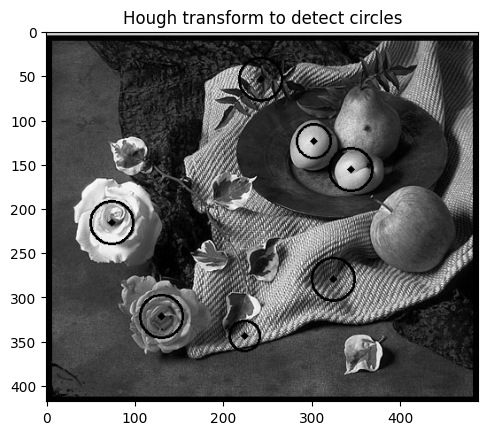

In [29]:
orig_img = objects.copy()
img = cv.GaussianBlur(objects.copy(), (3, 3), 1.5)
circles = cv.HoughCircles(img,cv.HOUGH_GRADIENT,1,20,
                            param1=50,param2=30,minRadius=12,maxRadius=25)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv.circle(orig_img, (i[0], i[1]), i[2], (0,255,0), 2)
    # draw the center of the circle
    cv.circle(orig_img, (i[0],i[1]), 2, (0,0,255), 3)
    
plt.imshow(orig_img, cmap = 'gray')
plt.title('Hough transform to detect circles')
plt.show()